In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape

2025-01-01 20:13:44.225937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735758824.241704    8974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735758824.246555    8974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 20:13:44.262860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare data and model

In [2]:
import art
from art.utils import load_mnist

batch_size=128

(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
x_steal = x_test0[indices[:len_steal]]
y_steal = y_test0[indices[:len_steal]]
x_test = x_test0[indices[len_steal:]]
y_test = y_test0[indices[len_steal:]]

im_shape = x_train[0].shape
def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


## Train and test model

In [3]:
from art.estimators.classification import TensorFlowV2Classifier

num_epochs = 5
model = get_model(num_classes=10, c1=32, c2=64, d1=128)
print("Original model training:")
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs)
print("Original model evaluation:")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1735758831.158390    8974 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Original model training:
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5645 - loss: 1.5295
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9094 - loss: 0.3050
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9328 - loss: 0.2269
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9459 - loss: 0.1815
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9548 - loss: 0.1501
Original model evaluation:
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9521 - loss: 0.1625
Test accuracy: 0.9464


## Define original Classifier

In [4]:

classifier_original = TensorFlowV2Classifier(model, clip_values=(0, 1), nb_classes=10, input_shape=(batch_size, 28,28))


## Run attacks

In [5]:
# Stealing from the unprotected classifier.
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
percentages = [0.001, 0.005, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]  # Generate percentages of samples to run the attacks on

for percentage in percentages:
    len_steal = int(len(x_test0) * percentage) 
    print(f'running attack for {len_steal} samples')
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        loss_object = tf.keras.losses.CategoricalCrossentropy()
        optimizer = tf.keras.optimizers.Adam()

        classifier_stolen = TensorFlowV2Classifier(
            model=model_stolen,
            clip_values=(0, 1),
            nb_classes=10,
            input_shape=(batch_size,28,28),
            loss_object=loss_object,
            optimizer=optimizer
        )
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

running attack for 10 samples


2025-01-01 20:15:32.416420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:15:32.427437: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:15:32.447185: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3154 - loss: 2.4574
Probabilistic CopycatCNN : 0.32182180881500244


2025-01-01 20:15:33.990967: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2828 - loss: 2.7525
Argmax CopycatCNN : 0.29309308528900146
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3183 - loss: 2.2579
Probabilistic KnockoffNets : 0.3257257342338562


2025-01-01 20:15:37.234179: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2652 - loss: 2.5877
Argmax KnockoffNets : 0.26856857538223267
running attack for 50 samples
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5632 - loss: 1.8054
Probabilistic CopycatCNN : 0.5616080164909363
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5549 - loss: 1.7968
Argmax CopycatCNN : 0.5485427379608154


2025-01-01 20:15:42.167638: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5158 - loss: 1.7785
Probabilistic KnockoffNets : 0.5105527639389038
311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4792 - loss: 1.9911
Argmax KnockoffNets : 0.4749748706817627
running attack for 100 samples
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7566 - loss: 0.7589
Probabilistic CopycatCNN : 0.7535353302955627
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7444 - loss: 0.8942
Argmax CopycatCNN : 0.7427272796630859
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7125 - loss: 0.9279
Probabilistic KnockoffNets : 0.7083838582038879
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7597 - loss: 0.7672
Argmax KnockoffNets : 0.7482828497886658
running attack for 500 samples


2025-01-01 20:15:54.416678: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8762 - loss: 0.4000
Probabilistic CopycatCNN : 0.8755789399147034
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8746 - loss: 0.4487
Argmax CopycatCNN : 0.8729473948478699
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8624 - loss: 0.4540
Probabilistic KnockoffNets : 0.8644210696220398
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8669 - loss: 0.4739
Argmax KnockoffNets : 0.8677894473075867
running attack for 1000 samples
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9121 - loss: 0.2978
Probabilistic CopycatCNN : 0.9103333353996277
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8902 - loss: 0.4087
Argmax CopycatCNN : 0.8949999809265137
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9127 - loss: 0.2901
Probabilistic KnockoffNets : 0.9168888926506042
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9155 - loss: 0.3060
Argmax KnockoffNets : 0.9107778072357178
running attack for 1

2025-01-01 20:16:47.117027: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9271 - loss: 0.3325
Argmax CopycatCNN : 0.9257500171661377
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9394 - loss: 0.2163
Probabilistic KnockoffNets : 0.9392499923706055
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9197 - loss: 0.3540
Argmax KnockoffNets : 0.9194999933242798
running attack for 2500 samples
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2665
Probabilistic CopycatCNN : 0.9276000261306763
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9338 - loss: 0.3118
Argmax CopycatCNN : 0.9327999949455261
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9395 - loss: 0.2305
Probabilistic KnockoffNets : 0.9369333386421204
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9323 - loss: 0.2713
Argmax KnockoffNets : 0.9323999881744385
running attack for 3000 samples
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9414 - loss: 0.1975
Probabilistic CopycatCNN : 0.93757

2025-01-01 20:20:23.331615: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9405 - loss: 0.2581
Argmax KnockoffNets : 0.9435999989509583


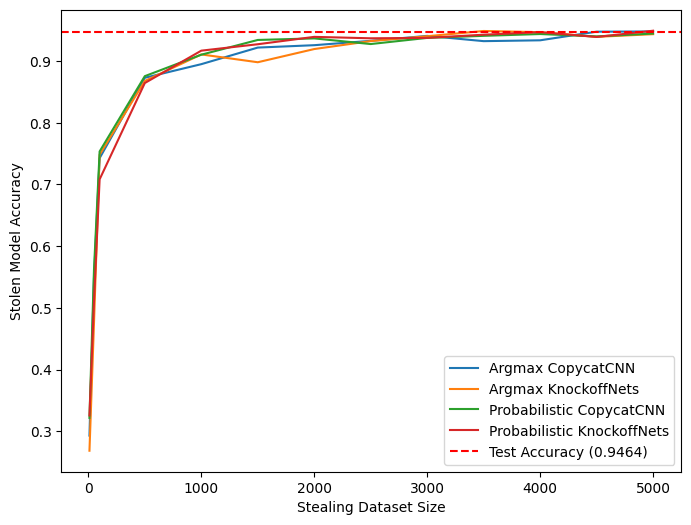

In [7]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
    
ax.axhline(y=test_accuracy, color='r', linestyle='--', 
            label=f"Test Accuracy ({test_accuracy:.4f})")
ax.legend()
plt.show()